# Homework 3

### CSCI 611, Spring 2024

Jesse Coulson


## Problem Statement
We are trying to analyze the titanic dataset to find the features that matter the most. The purpose is to test three different models, one with GaussianNB with all features, one with GaussianNB with custom features found from eda, and one with SGDClassifer with custom features to predict Survival of passengers

Subtasks:
 - Make visalizations and perform eda
 - Find performance metrics for each model
 - Test whether the models predict you to survive based on your metrics

In [1]:
#all the libraries needed for this ipynb
import seaborn as sns
import pandas as pd
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
import csv
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

## Reading in Data and Checking Format
 - Reading in data with read_csv from csv downlaoded from https://github.com/ageron/data/raw/main/titanic.tgz
 - Print out head of dataframe to exam
 - Examine info on data types of dataframe

In [2]:
#read in df
df= pd.read_csv("train.csv")

#orint data to see data and format
print(df.head())

#get info of types
df.info()

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

# Exploratory Data Analysis
 - creating visualisations to analyze features
 - looking for features that will be useful for prediction
 - getting rid of or transforming variables in format that does not go in current format into our estimators

## Checking and Transforming non Numeric Variables
 - Variables Name, Sex, Ticket, Cabin, Embarked are non numeric and either need to be transformed or not used

In [3]:
#Exploring Sex
#We need transform sex to numeric, can just map it to numbers 0 and 1
#Dont need to worry about heirarchy on binary var according to Professor Juliano
bin_var = {'Sex': {'female':0, 'male':1}} #can also use scikitlearn LabelEncoder
df = df.replace(bin_var)

#Exploring Cabin
#After looking at titanic dataset cabin is non numeric with lots of empty NaN values
#Want to get count of NaN to see if I should feature extract or just not use because so many missing values
nan_count = df['Cabin'].isna().sum()
length= len(df['Cabin'])

percentage = nan_count/length
print("Percentage of Cabin var that is NaN", percentage, "%\n") #77% of Cabin is missing, not worth using
df = df.drop(['Cabin'], axis=1) 

#Exploring Ticket and Name
#Appear completely unique
print(df["Ticket"])
print(df["Name"])
#dropping because  has not much value and each val is unique
df = df.drop(['Ticket', 'Name'], axis=1) 

#Exploring Embarked
#Appears to be non hierchal categorical variable with more than 2 categories
#should use one hot encoder then

#Get one hot encoder without sparse
onehot_enc = OneHotEncoder(sparse_output=False)
#transform vals
encoded = onehot_enc.fit_transform(df[['Embarked']])
#turn it into dataframe with column of same name
encoded_df = pd.DataFrame(encoded, columns=onehot_enc.get_feature_names_out(['Embarked']))

#concat with original dataframe
df = pd.concat([df, encoded_df], axis=1)

#drop oringonal non transformed Embarked
df = df.drop('Embarked', axis=1)

#Also Age has some NaNs that need to be replaced to be put into estimator
#replacing with mean age
mean = df['Age'].mean()
df['Age'] = df['Age'].fillna(mean)


Percentage of Cabin var that is NaN 0.7710437710437711 %

0             A/5 21171
1              PC 17599
2      STON/O2. 3101282
3                113803
4                373450
             ...       
886              211536
887              112053
888          W./C. 6607
889              111369
890              370376
Name: Ticket, Length: 891, dtype: object
0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen 'Carrie'
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name

### Non Numeric Variables Conclusion
In conclusion to deal with the non numeric variables, I explored them to decide on different options. For Sex since it is a binary var we can just map it to 0 and 1. 

For Cabin 77% of the data is missing NaN so we might as well not use this variable since too many are missing. 

Looking at the form of Ticket and Name, both of these variables seem to be unique. There would be no value for the model to use these for example theres only one person with a given name, it will tell us nothing about predicted value, and would just add noise if we encoded it numerically. So I will not be using these two variables in the estimator. 

Embarked is categorical variable with multiple categories so have to use one hot encoding because there is no heirarchy. There will now be four columns for embarked, Embarked_C, Embarked_S, Embarked_nan, and Embarked_Q

## Making Correlation Matrix
 - Making Correlation matrix to see how features relate to predicted feauture of Survived
 - Displaying the correlation matrix

In [4]:
#made it only for numeric values, one hot encoded vars cant go in
corr_matrix = df.corr(numeric_only= True)
corr_matrix["Survived"].sort_values(ascending=False)

Survived        1.000000
Fare            0.257307
Embarked_C      0.168240
Parch           0.081629
Embarked_nan    0.060095
Embarked_Q      0.003650
PassengerId    -0.005007
SibSp          -0.035322
Age            -0.069809
Embarked_S     -0.155660
Pclass         -0.338481
Sex            -0.543351
Name: Survived, dtype: float64

### Confusion Matrix Conclusion
From the confusion matrix there are three vairables that stand out, Sex, Fare, Passenger class. I will further explore these variables later.

## Creating Histograms of All the Variables 
- Seeing the distribution of passengers among the variables

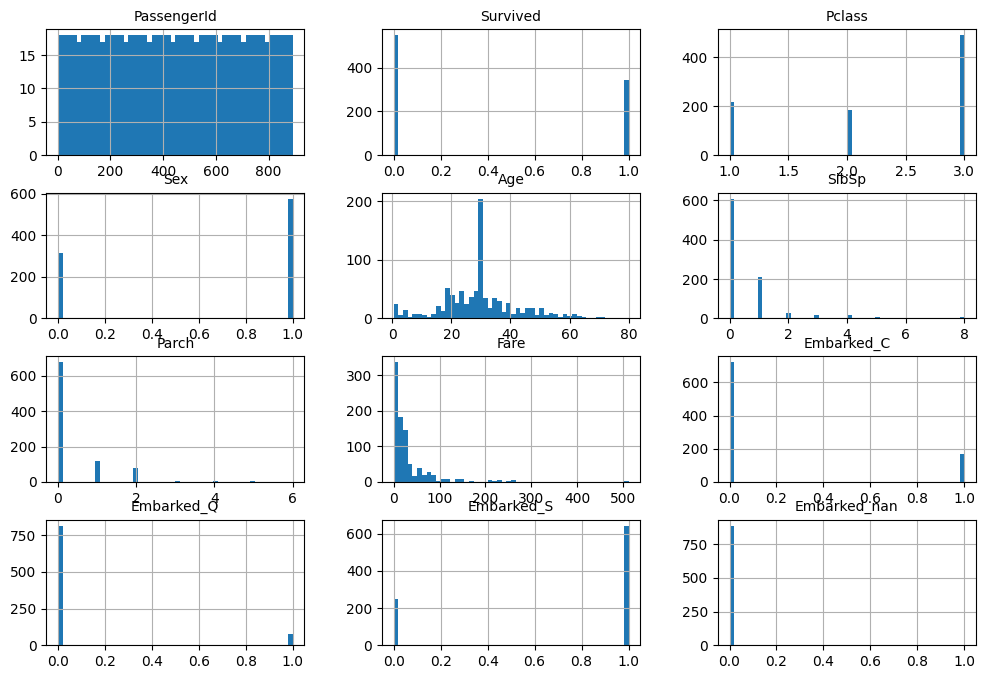

In [5]:
#histogram of the variables
plt.rc('font', size=10)
plt.rc('axes', labelsize=10, titlesize=10)
plt.rc('legend', fontsize=10)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

df.hist(bins=50, figsize=(12, 8))
plt.show()


### Histogram Conclusion
There are interesting distributions of the passengers. For example for Sex there was almost double as many male passenger as female. The Age distribution also had a wide range with the age that had the most people being around 20 years old. Its also interesting that most of the Fares were on the lower end with only a few outliers paying a lot of money for a ticket.

## Visualizations of the 3 Most Promising Variables
 - The variables I identified earlier with the highest correlation were Sex, Passenger Class, and Fare
 - I will use heatmaps to show how many passenger of each class survived for Sex and Passenger class to show relationship between these features and Survived
 - For Fare, I will use two boxplots of survived and not survived in relation to Fare to show relationship between Fare and Survived

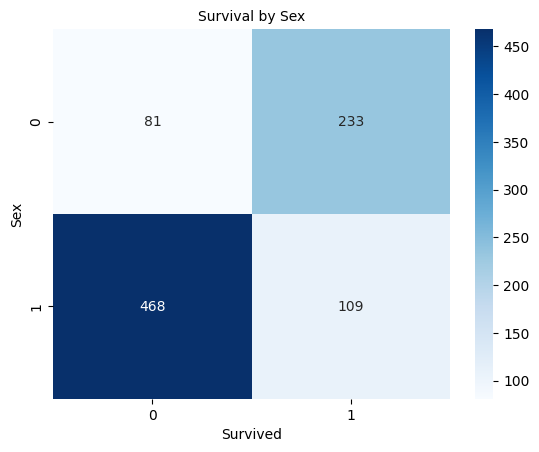

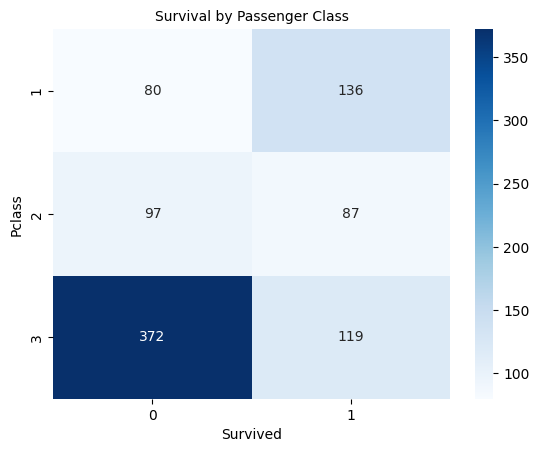

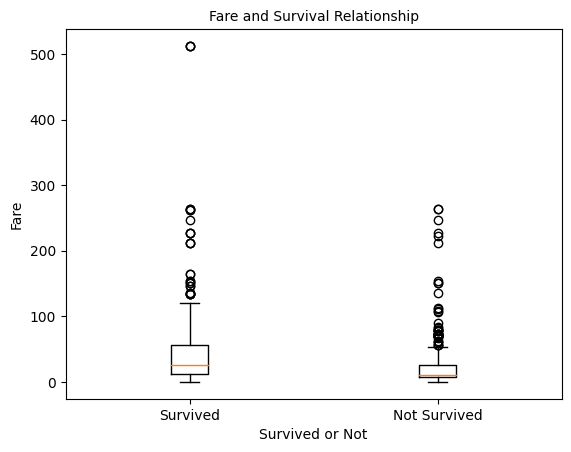

<Figure size 640x480 with 0 Axes>

In [6]:
#Making heatmap for Sex and Survival

#get frequency of col with crosstab
col_freq = pd.crosstab(df['Sex'], df['Survived'])

#cannot to display values on squares, fmt d for integer format
sns.heatmap(col_freq, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Survived')
plt.ylabel('Sex')
plt.title('Survival by Sex')
plt.show()
plt.clf()


#Making heatmap for Pclass and Survival
col_freq = pd.crosstab(df['Pclass'], df['Survived'])

sns.heatmap(col_freq, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Survived')
plt.ylabel('Pclass')
plt.title('Survival by Passenger Class')
plt.show()
plt.clf()

#making boxplots for Fare whether the passengers survived or not
#all the fares that survived
survived = df[df['Survived'] == 1]['Fare']

#all the fares that did not survive
not_survived= df[df['Survived'] == 0]['Fare']

#making the boxplots
plt.boxplot([survived, not_survived], labels=['Survived', 'Not Survived'])
plt.xlabel('Survived or Not')
plt.ylabel('Fare')
plt.title('Fare and Survival Relationship')
plt.show()
plt.clf()


### Conclusions of 3 Variable Visualization
From the heatmaps if it was truly random and sex/pclass did not affect survival rate, you would expect to see a 50 50 split for survival for each class. This is not the case. In the Sex heatmap 468 males died, while 109 survived. For female, 223 survived while 81 died. For pclass there are insights such as class 3 had 372 die and 119 live, while class 2 had closer to a 50 50 split. 

For the Boxplot you can see that as the fare goes up in price the average person survived more, the boxplot is longer and higher on the survived side than the not survived.

These graphs show that there is significant correlation between these variables and survival, I will use these three variables for the estimators


### Splitting data into training and test
 - splitting data with default 75, 25 split

In [7]:
#set aside 25% of data for testing after kfold to prove model works
X = df.drop('Survived', axis=1) #get all input feautures
y = df['Survived'] #get target feature

X_train, X_test, y_train, y_test = train_test_split(
   X, y, random_state=42)


## Using kfold Cross Validation to get Initial Performance
 - Creating classifier of GaussianNB on all features, my 3 selected features, and SGD Classifier on my selected features
 - using kfold cross validation with 5 folds to get accuracy across folds
 - display accuracy per fold and average accuracy

In [8]:
#GaussianNB all feautures
clf1 = GaussianNB()

#use cross validation and store accuracy for each fold
scores = cross_val_score(clf1, X_train, y_train, cv=5)
print("Accuracy from kfold cross validation on GaussianNB with all feautures:")
#show accuracy for each fold
i = 0
for score in scores:
    print(f"Fold {i} accuracy: {score}")
    i+=1

#print average accuracy across folds 
print(f"Average Accuracy: {sum(scores)/len(scores)}")

Accuracy from kfold cross validation on GaussianNB with all feautures:
Fold 0 accuracy: 0.8059701492537313
Fold 1 accuracy: 0.746268656716418
Fold 2 accuracy: 0.7238805970149254
Fold 3 accuracy: 0.6842105263157895
Fold 4 accuracy: 0.7368421052631579
Average Accuracy: 0.7394344069128044


In [9]:
#GaussianNB custom feautures
clf2 = GaussianNB()
X = X_train[["Sex", "Fare", "Pclass"]]
y = y_train

#use cross validation and store accuracy for each fold
scores = cross_val_score(clf2, X, y, cv=5)
print("Accuracy from kfold cross validation on GaussianNB with my feautures:")

#show accuracy for each fold
i = 0
for score in scores:
    print(f"Fold {i} accuracy: {score}")
    i+=1

#print average accuracy across folds 
print(f"Average Accuracy: {sum(scores)/len(scores)}")

Accuracy from kfold cross validation on GaussianNB with my feautures:
Fold 0 accuracy: 0.7835820895522388
Fold 1 accuracy: 0.8432835820895522
Fold 2 accuracy: 0.7164179104477612
Fold 3 accuracy: 0.7443609022556391
Fold 4 accuracy: 0.8120300751879699
Average Accuracy: 0.7799349119066322


In [10]:
#SGDClassifier custom feautures
clf3 = SGDClassifier(random_state=42)
X = X_train[["Sex", "Fare", "Pclass"]]
y = y_train

#use cross validation and store accuracy for each fold
scores = cross_val_score(clf3, X, y, cv=5)
print("Acc from kfold cross validation on SGDClassifier with my feautures:")

#show accuracy for each fold
i = 0
for score in scores:
    print(f"Fold {i} accuracy: {score}")
    i+=1

#print average accuracy across folds 
print(f"Average Accuracy: {sum(scores)/len(scores)}")

Acc from kfold cross validation on SGDClassifier with my feautures:
Fold 0 accuracy: 0.40298507462686567
Fold 1 accuracy: 0.8208955223880597
Fold 2 accuracy: 0.664179104477612
Fold 3 accuracy: 0.6917293233082706
Fold 4 accuracy: 0.631578947368421
Average Accuracy: 0.6422735944338458


## Kfold results
From the validation testing we can see that the best performing so far is the second model with custom features. We will now test with the testing data to verify our inital results and get more metrics to gain grater insights.

# Using Test Set and final metrics
 - Calculating accuracy on test set for each of the three clasifiers
 - Showing confusion matrix and metrics for performance of each model
 - Not changing default hyperparamaters, they should work great for the titanic dataset. Since we have not gone over Grid Search in the course yet I will just keep them as is

### Metrics for GaussianNB all Features

Accuracy on test set:  0.6995515695067265
Precision:  0.7391304347826086
Recall:  0.38202247191011235
F1 score:  0.5037037037037037


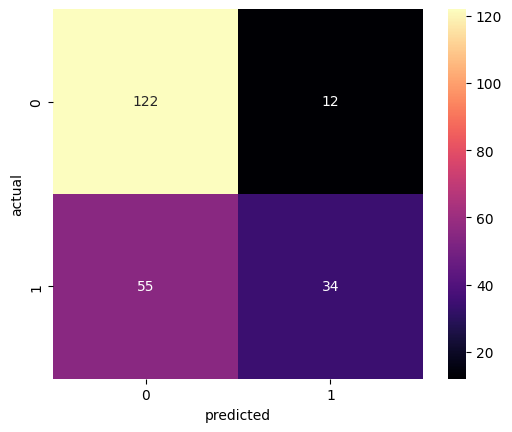

In [11]:
#still need to fit model, kfold did a fit per fold, need to do an overall fit
clf1.fit(X_train, y_train)

y_pred = clf1.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy on test set: ",acc)


#proportion of positives that were correctly identifed out of all actual positives
precision = precision_score(y_test, y_pred)
print("Precision: ", precision)

#how many positives were correctly identified
recall = recall_score(y_test, y_pred) 
print("Recall: ", recall)

#metric that combines precision and recall
f1 = f1_score(y_test, y_pred)
print("F1 score: ", f1)

conf_matrix = confusion_matrix(y_test, y_pred)

#confusion matrix visual derived from HOML 03
sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="magma", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual');

### Metrics for GaussianNB Custom Features

Accuracy on test set:  0.7713004484304933
Precision:  0.7065217391304348
Recall:  0.7303370786516854
F1 score:  0.718232044198895


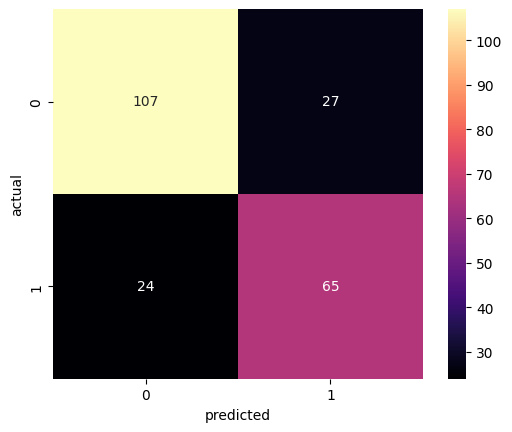

In [12]:
#get selected feautures
X = X_train[["Sex", "Fare", "Pclass"]]
y = y_train

X_t = X_test[["Sex", "Fare", "Pclass"]]
y_t = y_test

#still need to fit model, kfold did a fit per fold, need to do an overall fit
clf2.fit(X, y)


y_pred = clf2.predict(X_t)
acc = accuracy_score(y_t, y_pred)
print("Accuracy on test set: ",acc)



#proportion of positives that were correctly identifed out of all actual positives
precision = precision_score(y_t, y_pred)
print("Precision: ", precision)

#how many positives were correctly identified
recall = recall_score(y_t, y_pred) 
print("Recall: ", recall)

#metric that combines precision and recall
f1 = f1_score(y_t, y_pred)
print("F1 score: ", f1)

conf_matrix = confusion_matrix(y_t, y_pred)

#confusion matrix visual derived from HOML 03
sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="magma", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual');

### Metrics for SGDClassifier for Custom Features

Accuracy on test set:  0.7309417040358744
Precision:  0.7735849056603774
Recall:  0.4606741573033708
F1 score:  0.5774647887323945


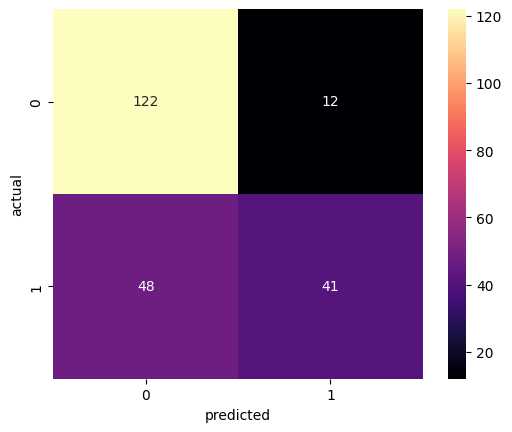

In [13]:
#get selected feautures
X = X_train[["Sex", "Fare", "Pclass"]]
y = y_train

X_t = X_test[["Sex", "Fare", "Pclass"]]
y_t = y_test

#still need to fit model, kfold did a fit per fold, need to do an overall fit
clf3.fit(X, y)


y_pred = clf3.predict(X_t)
acc = accuracy_score(y_t, y_pred)
print("Accuracy on test set: ",acc)


#proportion of positives that were correctly identifed out of all actual positives
precision = precision_score(y_t, y_pred)
print("Precision: ", precision)

#how many positives were correctly identified
recall = recall_score(y_t, y_pred) 
print("Recall: ", recall)

#metric that combines precision and recall
f1 = f1_score(y_t, y_pred)
print("F1 score: ", f1)

conf_matrix = confusion_matrix(y_t, y_pred)

#confusion matrix visual derived from HOML 03
sns.heatmap(conf_matrix, square=True, annot=True, fmt='d', cmap="magma", cbar=True)
plt.xlabel('predicted')
plt.ylabel('actual');

# Conclusion of metrics
From these three models the best performing model was GaussianNB with my custom features(Model2), the second best was SGDClassifier with custom features(Model3), and the worst performing was GaussianNB with all features(Model1).  

The best model was signficantly more accurate than the worst model with 77% accuracy as opposed to 69%.

Looking at the metrics of precision, recall, and F1 score, Model1 had the largest variance between its metric. The recall is almost half the precision, lowering the F1 score. What this means is the model is bad at identifying positives. Model2 and Model3 have a precision and recall which is similar, but Model2 is almost .1 higher on all metrics.

Looking at the confusion matricies, Model1 had a lot of false negatives, Model2 and Model3 had almost equal false negative and false positive. Model1 correctly predicted 156/223, Model2 correctly predicted 172/223 and Model3 correctly predicted 163/223.

## Predicting my survival rate on the 3 models
 - For the features for the model with all features I will just input as accurate as possible values for things like PassengerId and Embarked which do not fully apply to me

In [14]:
#predicting for model1, GaussianNB with all features
#inputting features
my_features = [[564, 2, 1, 26, 0, 0, 30, 1, 0,0,0]]

#getting names of features in same order as features
feature_names = ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 
                 'Embarked_Q', 'Embarked_S', 'Embarked_nan']
#creating dataframe for prediction input so no warning about feature names
my_df = pd.DataFrame(my_features, columns=feature_names)

#predicting survival or not
my_prediction = clf1.predict(my_df)
print("Model1 prediction: ",my_prediction)


#predicting for model2, GaussianNB with custom features
my_features = [[1,30,2]]
feature_names = ['Sex', 'Fare', 'Pclass']
my_df = pd.DataFrame(my_features, columns=feature_names)
my_prediction = clf2.predict(my_df)
print("Model2 prediction: ",my_prediction)

#predicting for model3, SGDClassifier with custom features
my_features = [[1,30,2]]
feature_names = ['Sex', 'Fare', 'Pclass']
my_df = pd.DataFrame(my_features, columns=feature_names)
my_prediction = clf3.predict(my_df)
print("Model3 prediction: ",my_prediction)

Model1 prediction:  [0]
Model2 prediction:  [0]
Model3 prediction:  [0]


## Results of Time Travel
 - As you can see if I time traveled to the titanic all 3 models predict me to not survive. This is probably to do with what we discussed in clas about the biggest factors being male. Hopefully no time machines for me then.